# Filter public/charter school data into team-specific data sets

Author(s): Jaren Haber<br>
Project Manager: Jaren Haber, PhD Candidate <br>
Contact: jhaber@berkeley.edu

Institution: University of California, Berkeley <br>
Program: Undergraduate Research Apprentice Program (URAP) <br>

Date created: Nov. 27, 2018<br>
Last modified: Nov. 27, 2018

Description: 

## Initialize

### Import packages

In [1]:
import pandas as pd # For working with DataFrames
import gc # For speeding up loading pickle files ('gc' = 'garbage collector')
import ast # For working with strings
import numpy as np # For numerical things
import re # For cleaning webtext
import _pickle as cPickle # Optimized version of pickle
import gc # For managing garbage collector

### Define file paths

In [2]:
# Input files:
charters_path = "../../nowdata/charters_2015.pkl"
pubschools_path = "../../nowdata/pubschools_2015.pkl"

charters_small_loc = "../../nowdata/backups/charters_parsed_03-04_no-text_SMALL.csv"
ACSsmall_loc = "../data/ACS_2016_sd-merged_SMALL.csv"
ACSfull_loc = "../data/ACS_2016_sd-merged_FULL.csv"

In [3]:
# Output files:
charters_storepath = "../../nowdata/backups/charters_full_2015_250_v2a.pkl"
pubschools_storepath = "../../nowdata/backups/pubschools_full_2015_CRDC.pkl"

geo_storepath = "../../nowdata/backups/charters_geo_2015_v2a.csv"
geoteam_path = "../../geospatial/data/charter_geo_2015_v2a.csv"

stats_storepath = "../../nowdata/backups/charters_stats_2015_v2a.csv"

### Define helper functions

In [4]:
def convert_df(df, ignore_list):
    """Makes a Pandas DataFrame more memory-efficient through intelligent use of Pandas data types: 
    specifically, by storing columns with repetitive Python strings not with the object dtype for unique values 
    (entirely stored in memory) but as categoricals, which are represented by repeated integer values. This is a 
    net gain in memory when the reduced memory size of the category type outweighs the added memory cost of storing 
    one more thing. As such, this function checks the degree of redundancy for a given column before converting it."""
    
    # Remove specified columns to avoid conversion errors, those that shouldn't have their dtype converted
    # e.g., columns that are large lists of tuples, like "WEBTEXT" or "CMO_WEBTEXT", should stay as 'object' dtype
    if len(ignore_list)>0:
        ignore_df = df[ignore_list]
        df.drop(ignore_list, axis=1, inplace=True)
    
    converted_df = pd.DataFrame() # Initialize DF for memory-efficient storage of strings (object types)
    df_obj = df.select_dtypes(include=['object']).copy() # Filter to only those columns of object data type

    # Loop through all columns that have 'object' dtype, b/c we especially want to convert these if possible:
    for col in df.columns: 
        if col in df_obj: 
            num_unique_values = len(df_obj[col].unique())
            num_total_values = len(df_obj[col])
            if (num_unique_values / num_total_values) < 0.5: # Only convert data types if at least half of values are duplicates
                converted_df.loc[:,col] = df[col].astype('category') # Store these columns as dtype "category"
            else: 
                converted_df.loc[:,col] = df[col]
        else:    
            converted_df.loc[:,col] = df[col]
                      
    # Downcast dtype to reduce memory drain
    converted_df.select_dtypes(include=['float']).apply(pd.to_numeric,downcast='float')
    converted_df.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='signed')
    
    # Reintroduce ignored columns into resulting DF
    if len(ignore_list)>0:
        for col in ignore_list:
            converted_df[col] = ignore_df[col]
    
    return converted_df

In [5]:
def quickpickle_load(picklepath):
    '''Very time-efficient way to load pickle-formatted objects into Python.
    Uses C-based pickle (cPickle) and gc workarounds to facilitate speed. 
    Input: Filepath to pickled (*.pkl) object.
    Output: Python object (probably a list of sentences or something similar).'''

    with open(picklepath, 'rb') as loadfile:
        
        gc.disable() # disable garbage collector
        outputvar = cPickle.load(loadfile) # Load from picklepath into outputvar
        gc.enable() # enable garbage collector again
    
    return outputvar

In [6]:
def quickpickle_dump(dumpvar, picklepath):
    '''Very time-efficient way to dump pickle-formatted objects from Python.
    Uses C-based pickle (cPickle) and gc workarounds to facilitate speed. 
    Input: Python object (probably a list of sentences or something similar).
    Output: Filepath to pickled (*.pkl) object.'''

    with open(picklepath, 'wb') as destfile:
        
        gc.disable() # disable garbage collector
        cPickle.dump(dumpvar, destfile) # Dump dumpvar to picklepath
        gc.enable() # enable garbage collector again

In [7]:
def check_df(DF, colname):
    """Displays basic info about a dataframe in memory.
    Input: Pandas DataFrame object
    Output: printed basic stats:    # rows and columns, 
                                    # duplicates by colname, 
                                    column names and, if missing data, the # missing cases."""
    
    # Show DF info, including # duplicates by colname
    print("# rows and cols: ", str(DF.shape))
    print("# duplicates by " + str(colname) + ": " + str(sum(DF.duplicated(subset=colname, keep='first'))))

    print("\nColumns and # missing cases (if any): ")
    for col in list(DF):
        missed = sum(DF[col].isnull())
        if missed > 0:
            print(col + ": " + str(missed) + " missing")
        else:
            print(col)
    
    #print("\nALL column names: ", list(DF))

In [8]:
def load_filtered_df(dfpath, keepcols):
    """Quickly loads a Pandas DataFrame from file (either .csv or .pkl format), 
    keeps only those variables in keepvars (if not an empty list), and makes the DF memory-efficient.
    Input: file path to DataFrame (.csv or .pkl), list of variables to keep from said DF (or empty list, to keep all cols)
    Output: DF with reduced variables and with memory-efficient dtypes."""
    
    if len(keepcols)>0:
        if dfpath.endswith(".csv"):
            newdf = pd.read_csv(dfpath, usecols=keepcols, low_memory=False)
        elif dfpath.endswith(".pkl"):
            newdf = quickpickle_load(dfpath)
            newdf = newdf[keepcols]
            
    else:
        if dfpath.endswith(".csv"):
            newdf = pd.read_csv(dfpath, low_memory=False)
        elif dfpath.endswith(".pkl"):
            newdf = quickpickle_load(dfpath)
    
    if "WEBTEXT" in list(newdf) or "CMO_WEBTEXT" in list(newdf):
        newdf = convert_df(newdf, ["WEBTEXT", "CMO_WEBTEXT"])
    else:
        newdf = convert_df(newdf, [])
    
    if "NCESSCH" in list(newdf):
        newdf["NCESSCH"] = newdf["NCESSCH"].astype(float)
        check_df(newdf, "NCESSCH")
    
    return newdf

In [9]:
def density_calc(somedf, fulldf, groupvar, uniqueid, filtervar):
    """Calculates total number of entities (rows) in a given DataFrame that share a given clustering/group variable.
    Uses uniqueid to identify number of independent entities. Finally merges the density with the given DF.
    Uses a more general DF (e.g., all public schools) to calculate density of both all entities and 
    specific entities (identified using filtervar from within general DF; e.g., charter schools).
    Useful for calculating the density of charter & public schools in a given school district.
    
    Args: 
        Specific (and detailed) DataFrame, 
        more general DF (for context info, e.g. all public schools), 
        variable to group by, unique IDs (for each entity), 
        variable name for density,
        variable to filter by (e.g., charter identifier).
    Returns: 
        Density columns ready to be added to DataFrame."""

    # Use filtering variable to filter to more specific level (i.e., to only charter schools)
    filtered_df = fulldf[fulldf[filtervar] == 1]
    
    # Keep only relevant variables from fulldf for finding density (not necessary if fulldf already trimmed)
    fulldf = fulldf[[groupvar, uniqueid]]
    
    # Generate 2-element DFs grouped by groupvar, both total and filtered, 
    # identifying distinct entities using uniqueid:
    grouped_total = fulldf.groupby([groupvar])[uniqueid].count().reset_index(name="Total_num_entities")
    grouped_filtered = filtered_df.groupby([groupvar])[uniqueid].count().reset_index(name="Filtered_num_entities")
    
    # Create density columns matched to original DF
    total_density = pd.merge(somedf, grouped_total, how='outer', on=[groupvar])["Total_num_entities"]
    filtered_density = pd.merge(somedf, grouped_filtered, how='outer', on=[groupvar])["Filtered_num_entities"]
    
    #new_frame[densityvar] = new_frame['All_school_counts']/merge_frame[("Area (Land)", "Geo_AREALAND")]
    
    return total_density, filtered_density

In [10]:
def write_list(file_path, textlist):
    """Writes textlist to file_path.
    Input: Path to file, list of strings
    Output: Nothing (saved to disk)"""
    
    with open(file_path, 'w') as file_handler:
        
        for elem in textlist:
            file_handler.write("{}\n".format(elem))
    
    return    

In [11]:
def load_list(file_path):
    """Loads list into memory. Must be assigned to object.
    Input: Path to file
    Output: List object"""
    
    textlist = []
    with open(file_path) as file_handler:
        line = file_handler.readline()
        while line:
            textlist.append(line)
            line = file_handler.readline()
    return textlist

## Load & filter data

In [12]:
acs = pd.read_csv(ACSfull_loc, header = [0, 1], encoding="latin1", low_memory=False) # School district social data (ACS, 2012-16)
print(acs.shape)
list(acs)

(13406, 126)


[('FIPS', 'Geo_FIPS'),
 ('Name of Area', 'Geo_NAME'),
 ('Qualifying Name', 'Geo_QName'),
 ('State/U.S.-Abbreviation (USPS)', 'Geo_STUSAB'),
 ('Summary Level', 'Geo_SUMLEV'),
 ('File Identification', 'Geo_FILEID'),
 ('Logical Record Number', 'Geo_LOGRECNO'),
 ('State (FIPS)', 'Geo_STATE'),
 ('School District (Elementary)', 'Geo_SDELM'),
 ('School District (Secondary)', 'Geo_SDSEC'),
 ('School District (Unified)', 'Geo_SDUNI'),
 ('Geographic Identifier', 'Geo_GEOID'),
 ('Area (Land)', 'Geo_AREALAND'),
 ('Area (Water)', 'Geo_AREAWATR'),
 ('Total Population', 'SE_T002_001'),
 ('Population Density (Per Sq. Mile)', 'SE_T002_002'),
 ('Area (Land)', 'SE_T002_003'),
 ('% Total Population: Under 18 Years', 'PCT_SE_T009_002'),
 ('% Total Population: 18 to 34 Years', 'PCT_SE_T009_003'),
 ('% Total Population: 35 to 64 Years', 'PCT_SE_T009_004'),
 ('% Total Population: 65 and Over', 'PCT_SE_T009_005'),
 ('% Total Population: White Alone', 'PCT_SE_T013_002'),
 ('% Total Population: Black or African 

In [13]:
charters_smalldf = load_filtered_df(charters_small_loc, [])

# rows and cols:  (6972, 32)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
STATENAME
LEAID
LEA_NAME
NCESSCH
SCH_NAME
TOTFRL: 218 missing
AM: 218 missing
AS: 218 missing
BL: 218 missing
HI: 218 missing
HP: 218 missing
MEMBER: 218 missing
TR: 218 missing
TITLEI: 624 missing
FTE: 218 missing
YEAR_OPENED: 70 missing
YEAR_CLOSED: 6484 missing
LATCODE: 114 missing
LONGCODE: 114 missing
LOCALE: 114 missing
ALL_MTH00PCTPROF_1415: 688 missing
ALL_RLA00PCTPROF_1415: 688 missing
ADDRESS14
ess_count: 1596 missing
prog_count: 1596 missing
rit_count: 1596 missing
ess_strength: 2016 missing
prog_strength: 2014 missing
AGE: 70 missing
PCTETH: 259 missing
PLACE: 114 missing
TOTETH: 218 missing


In [14]:
# Load full public school data set - just the cols needed to count density
pubdf_small = load_filtered_df(pubschools_path, ["NCESSCH", "GEO_LEAID", "LEAID", "TRUE_CHARTER", "SY_STATUS15"])

# rows and cols:  (136825, 5)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
NCESSCH
GEO_LEAID: 34502 missing
LEAID: 36593 missing
TRUE_CHARTER
SY_STATUS15: 34699 missing


In [15]:
# Define variables to keep from full charter data set
keepvars = ['LEVEL', 'MEMBER', 'SE_T002_002', 'AGE', 'PCTETH', 'PCTFRL', 'PCTETH_SD', 'PCT_SE_T113_002', 
            'ESS_VALID_RATIO', 'PROG_VALID_RATIO', 'INQUIRY_RATIO', 'DISCIPLINE_RATIO', 'STABR', 
            'LEAID', 'GEO_LEAID', 'NCESSCH', 'SY_STATUS15', 'close_rate16', 'TITLEI', 
            'LAT1516', 'LON1516', 'ADDRESS16', 'ALL_RLA00PCTPROF_1516', 'ALL_MTH00PCTPROF_1516']

expul_cols = ['TOT_DISCWODIS_EXPWE_M', 'TOT_DISCWODIS_EXPWE_F', 'TOT_DISCWODIS_EXPWOE_M', 
              'TOT_DISCWODIS_EXPWOE_F', 'TOT_DISCWDIS_EXPWE_IDEA_M', 'TOT_DISCWDIS_EXPWE_IDEA_F', 
              'TOT_DISCWDIS_EXPWOE_IDEA_M', 'TOT_DISCWDIS_EXPWOE_IDEA_F']

In [16]:
# Load and filter charter data set
charterdf = load_filtered_df(charters_path, keepvars+expul_cols)

# rows and cols:  (10965, 32)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
LEVEL: 3577 missing
MEMBER: 4034 missing
SE_T002_002: 7951 missing
AGE: 595 missing
PCTETH: 4058 missing
PCTFRL: 4037 missing
PCTETH_SD: 7892 missing
PCT_SE_T113_002: 7892 missing
ESS_VALID_RATIO: 4103 missing
PROG_VALID_RATIO: 4103 missing
INQUIRY_RATIO: 4103 missing
DISCIPLINE_RATIO: 4103 missing
STABR: 3577 missing
LEAID: 4016 missing
GEO_LEAID: 3612 missing
NCESSCH
SY_STATUS15: 3619 missing
close_rate16
TITLEI: 4597 missing
LAT1516: 3613 missing
LON1516: 3613 missing
ADDRESS16: 3532 missing
ALL_RLA00PCTPROF_1516: 4663 missing
ALL_MTH00PCTPROF_1516: 4665 missing
TOT_DISCWODIS_EXPWE_M: 5368 missing
TOT_DISCWODIS_EXPWE_F: 5368 missing
TOT_DISCWODIS_EXPWOE_M: 5368 missing
TOT_DISCWODIS_EXPWOE_F: 5368 missing
TOT_DISCWDIS_EXPWE_IDEA_M: 5368 missing
TOT_DISCWDIS_EXPWE_IDEA_F: 5368 missing
TOT_DISCWDIS_EXPWOE_IDEA_M: 5368 missing
TOT_DISCWDIS_EXPWOE_IDEA_F: 5368 missing


In [26]:
# Filter to only open schools
filtered_STATUS = (charterdf['SY_STATUS15'] == 1) | (charterdf['SY_STATUS15'] == 3) | (charterdf['SY_STATUS15'] == 4) | (charterdf['SY_STATUS15'] == 5) | (charterdf['SY_STATUS15'] == 8)

chopendf = charterdf.loc[filtered_STATUS]
check_df(chopendf, "NCESSCH")

# rows and cols:  (6947, 32)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
LEVEL
MEMBER: 19 missing
SE_T002_002: 4076 missing
AGE: 19 missing
PCTETH: 43 missing
PCTFRL: 22 missing
PCTETH_SD: 4017 missing
PCT_SE_T113_002: 4017 missing
ESS_VALID_RATIO: 647 missing
PROG_VALID_RATIO: 647 missing
INQUIRY_RATIO: 647 missing
DISCIPLINE_RATIO: 647 missing
STABR
LEAID: 3 missing
GEO_LEAID
NCESSCH
SY_STATUS15
close_rate16
TITLEI: 908 missing
LAT1516
LON1516
ADDRESS16: 33 missing
ALL_RLA00PCTPROF_1516: 649 missing
ALL_MTH00PCTPROF_1516: 651 missing
TOT_DISCWODIS_EXPWE_M: 1360 missing
TOT_DISCWODIS_EXPWE_F: 1360 missing
TOT_DISCWODIS_EXPWOE_M: 1360 missing
TOT_DISCWODIS_EXPWOE_F: 1360 missing
TOT_DISCWDIS_EXPWE_IDEA_M: 1360 missing
TOT_DISCWDIS_EXPWE_IDEA_F: 1360 missing
TOT_DISCWDIS_EXPWOE_IDEA_M: 1360 missing
TOT_DISCWDIS_EXPWOE_IDEA_F: 1360 missing


In [27]:
# Create new variable with density of charter schools
chopendf["PUBLIC_DENSITY"], chopendf["CHARTER_DENSITY"] = density_calc(chopendf, pubdf_small, "GEO_LEAID", "NCESSCH", "TRUE_CHARTER")

# Fill missing charter densities with zero, because otherwise districts with no charters show NaN
chopendf["CHARTER_DENSITY"] = chopendf["CHARTER_DENSITY"].fillna(0)

#charterdf[["PUBLIC_DENSITY", "CHARTER_DENSITY"]]
check_df(chopendf, "NCESSCH")

# rows and cols:  (6947, 34)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
LEVEL
MEMBER: 19 missing
SE_T002_002: 4076 missing
AGE: 19 missing
PCTETH: 43 missing
PCTFRL: 22 missing
PCTETH_SD: 4017 missing
PCT_SE_T113_002: 4017 missing
ESS_VALID_RATIO: 647 missing
PROG_VALID_RATIO: 647 missing
INQUIRY_RATIO: 647 missing
DISCIPLINE_RATIO: 647 missing
STABR
LEAID: 3 missing
GEO_LEAID
NCESSCH
SY_STATUS15
close_rate16
TITLEI: 908 missing
LAT1516
LON1516
ADDRESS16: 33 missing
ALL_RLA00PCTPROF_1516: 649 missing
ALL_MTH00PCTPROF_1516: 651 missing
TOT_DISCWODIS_EXPWE_M: 1360 missing
TOT_DISCWODIS_EXPWE_F: 1360 missing
TOT_DISCWODIS_EXPWOE_M: 1360 missing
TOT_DISCWODIS_EXPWOE_F: 1360 missing
TOT_DISCWDIS_EXPWE_IDEA_M: 1360 missing
TOT_DISCWDIS_EXPWE_IDEA_F: 1360 missing
TOT_DISCWDIS_EXPWOE_IDEA_M: 1360 missing
TOT_DISCWDIS_EXPWOE_IDEA_F: 1360 missing
PUBLIC_DENSITY
CHARTER_DENSITY


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [28]:
# Combine columns for expulsions
#chopendf["Total Number of Students who received an expulsion"] = chopendf[expul_cols].sum(axis=1)
chopendf["Total Number of Students who received an expulsion"] = \
chopendf["TOT_DISCWODIS_EXPWE_M"] + chopendf["TOT_DISCWODIS_EXPWE_F"] + \
chopendf["TOT_DISCWODIS_EXPWOE_M"] + chopendf["TOT_DISCWODIS_EXPWOE_F"] + chopendf["TOT_DISCWDIS_EXPWE_IDEA_M"] + \
chopendf["TOT_DISCWDIS_EXPWE_IDEA_F"] + chopendf["TOT_DISCWDIS_EXPWOE_IDEA_M"] + chopendf["TOT_DISCWDIS_EXPWOE_IDEA_F"]

# Drop the specific expulsion columns
chopendf.drop(columns=expul_cols, inplace=True, axis=1)

# Recode variables:
#chopendf["PLACE"] = chopendf["LOCALE15"].map({11.0:"City", 12.0:"City", 13.0:"City", 21.0:"Suburb", 22.0:"Suburb", 23.0:"Suburb", 31.0:"Town", 32.0:"Town", 33.0:"Town", 41.0:"Rural", 42.0:"Rural", 43.0:"Rural"}).astype('category')
#chopendf["TITLEI"] = chopendf["TITLEI"].map({"Yes":1.0, "No":0.0}).astype('category')

# Create a new column called chopendf.ETHNIC_ISOLATED where the value is 1
# if chopendf.PCTETH is greater than 99.0 and 0 if not
chopendf["ETHNIC_ISOLATED"] = np.where(chopendf["PCTETH"]>=0.99, 1, 0)

chopendf = convert_df(chopendf, []) # Make memory-efficient
check_df(chopendf, "NCESSCH") # Check missing vars

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# rows and cols:  (6947, 28)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
LEVEL
MEMBER: 19 missing
SE_T002_002: 4076 missing
AGE: 19 missing
PCTETH: 43 missing
PCTFRL: 22 missing
PCTETH_SD: 4017 missing
PCT_SE_T113_002: 4017 missing
ESS_VALID_RATIO: 647 missing
PROG_VALID_RATIO: 647 missing
INQUIRY_RATIO: 647 missing
DISCIPLINE_RATIO: 647 missing
STABR
LEAID: 3 missing
GEO_LEAID
NCESSCH
SY_STATUS15
close_rate16
TITLEI: 908 missing
LAT1516
LON1516
ADDRESS16: 33 missing
ALL_RLA00PCTPROF_1516: 649 missing
ALL_MTH00PCTPROF_1516: 651 missing
PUBLIC_DENSITY
CHARTER_DENSITY
Total Number of Students who received an expulsion: 1360 missing
ETHNIC_ISOLATED


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Merge ACS data again using new GEO_LEAID

In [32]:
acs = pd.read_csv(ACSfull_loc, header = [0, 1], encoding="latin1", low_memory=False) # School district social data (ACS, 2012-16)

acs_tups = [('FIPS', 'Geo_FIPS'), 
            ('% Total Population: White Alone', 'PCT_SE_T013_002'), 
            ('% Families: Income in Below Poverty Level', 'PCT_SE_T113_002'), 
            ('Population Density (Per Sq. Mile)', 'SE_T002_002'), 
            ("% Population 25 Years and Over: Bachelor's Degree", 'PCT_SE_T025_005'), 
            ("% Population 25 Years and Over: Master's Degree", 'PCT_SE_T025_006'), 
            ('% Population 25 Years and Over: Professional School Degree', 'PCT_SE_T025_007'), 
            ('% Population 25 Years and Over: Doctorate Degree', 'PCT_SE_T025_008'), 
            ('% Civilian Population in Labor Force 16 Years and Over: Unemployed', 'PCT_SE_T037_003'), 
            ('% Total Population: Foreign Born', 'PCT_SE_T133_003')]

# Keep only ACS cols we need
acs = acs[acs_tups]

# Get list of ACS vars to drop from school dfs (to avoid risk of duplication):
acsvars_ch, acsvars_pub = [], []
for var in list(acs):
    if var[1] in list(chopendf) and var[1] not in acsvars_ch:
        acsvars_ch.append(var[1])
    #if var[1] in list(pubsdf) and var[1] not in acsvars_pub:
    #    acsvars_pub.append(var[1])
    #if var in list(pubsdf) and var not in acsvars_pub:
    #    acsvars_pub.append(var)

mergevar = "GEO_LEAID"
acs[mergevar] = acs[("FIPS", "Geo_FIPS")] # Simplifies merging process
chopendf = chopendf.drop(acsvars_ch, axis=1) # Drop ACS vars
chopendf = pd.merge(chopendf, acs, how="left", on=mergevar) # Merge

# Rename ACS vars so they're single index--and thus easier to work with
rename_dict = dict(((x,y),y) for x,y in acs_tups)
chopendf.rename(index=str, columns=rename_dict, inplace=True) # Rename columns using renaming dict

chopendf["PCTBA_SD"] = chopendf["PCT_SE_T025_005"] + chopendf["PCT_SE_T025_006"] + chopendf['PCT_SE_T025_007'] + chopendf['PCT_SE_T025_008'] # "% Population 25 Years and Over: Bachelor's Degree or Higher" (school district)
chopendf['PCTETH_SD'] = 1 - chopendf['PCT_SE_T013_002'] # "% Total Population: Nonwhite" (school district)

# Clean up by dropping vars not needed for analysis
chopendf.drop(columns=["NCESSCH", "SY_STATUS15", "LEAID", "GEO_LEAID", "PCT_SE_T013_002", "PCT_SE_T025_005", "PCT_SE_T025_006", "PCT_SE_T025_007", "PCT_SE_T025_008"], 
               axis=1, inplace=True)

# Rename variables
chopendf = chopendf.rename(
    index=str, columns={'LEVEL':'level', 
                        'MEMBER':'students', 
                        'SE_T002_002':'popdensity', 
                        'PCT_SE_T037_003':'unemployment', 
                        'PCT_SE_T133_003':'foreignborn', 
                        'AGE':'age', 
                        'PCTETH':'pocschool', 
                        'ETHNIC_ISOLATED':'ethnicisolated', 
                        'PCTFRL':'povertyschool', 
                        'PCTETH_SD':'pocsd', 
                        'PCT_SE_T113_002':'povertysd', 
                        'ESS_VALID_RATIO':'traditional', 
                        'PROG_VALID_RATIO':'progressive', 
                        'INQUIRY_RATIO':'inquiry', 
                        'DISCIPLINE_RATIO':'discipline', 
                        'Total Number of Students who received an expulsion':'expulsions', 
                        'STABR':'state', 
                        'PCTBA_SD':'collegesd', 
                        'close_rate16':'closerate', 
                        'ADDRESS16':'address', 
                        'LAT1516':'latitude', 
                        'LON1516':'longitude', 
                        'PLACE':'locale', 
                        'TITLEI':'titlei', 
                        'ALL_RLA00PCTPROF_1516':'readingscore', 
                        'ALL_MTH00PCTPROF_1516':'mathscore', 
                        'PUBLIC_DENSITY':'publicdensity', 
                        'CHARTER_DENSITY':'charterdensity'})

check_df(chopendf, "students") # Check missing vars

# rows and cols:  (6947, 28)
# duplicates by students: 5671

Columns and # missing cases (if any): 
level
students: 19 missing
age: 19 missing
pocschool: 43 missing
povertyschool: 22 missing
pocsd: 31 missing
traditional: 647 missing
progressive: 647 missing
inquiry: 647 missing
discipline: 647 missing
state
closerate
titlei: 908 missing
latitude
longitude
address: 33 missing
readingscore: 649 missing
mathscore: 651 missing
publicdensity
charterdensity
expulsions: 1360 missing
ethnicisolated
Geo_FIPS: 31 missing
povertysd: 31 missing
popdensity: 49 missing
unemployment: 31 missing
foreignborn: 31 missing
collegesd: 31 missing


/opt/conda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


## Create, clean, & reorder data

### Data for statistics team (and sharing)

In [33]:
# Retain and reorder variables for stats team
statsdf = chopendf[['inquiry', 'discipline', 'traditional', 'progressive', 
                    'readingscore', 'mathscore', 
                    'pocschool', 'pocsd', 'povertyschool', 'povertysd', 
                    'students', 'age', 'expulsions', 'titlei', 'ethnicisolated', 
                    'collegesd', 'popdensity', 'unemployment', 'foreignborn', 
                    'closerate', 'publicdensity', 'charterdensity']]

# Clean up by dropping schools missing core variables
statsdf = statsdf[statsdf["students"].notnull()]
statsdf = statsdf[statsdf["povertyschool"].notnull()]
statsdf = statsdf[statsdf["povertysd"].notnull()]
statsdf = statsdf[statsdf["pocschool"].notnull()]
statsdf = statsdf[statsdf["pocsd"].notnull()]
statsdf = statsdf[statsdf["age"].notnull()]
statsdf = statsdf[statsdf["inquiry"].notnull()]
statsdf = statsdf[statsdf["discipline"].notnull()]

check_df(statsdf, "students") # Check missing vars again

# rows and cols:  (6238, 22)
# duplicates by students: 4975

Columns and # missing cases (if any): 
inquiry
discipline
traditional
progressive
readingscore: 566 missing
mathscore: 568 missing
pocschool
pocsd
povertyschool
povertysd
students
age
expulsions: 1079 missing
titlei: 801 missing
ethnicisolated
collegesd
popdensity: 16 missing
unemployment
foreignborn
closerate
publicdensity
charterdensity


### Data for geospatial team

In [34]:
# Retain and reorder variables for geospatial team
geodf = chopendf[['inquiry', 'discipline', 'traditional', 'progressive', 
                  'readingscore', 'mathscore', 
                  'pocschool', 'pocsd', 'povertyschool', 'povertysd', 
                  'students', 'age', 'expulsions', 'titlei', 'ethnicisolated', 
                  'collegesd', 'popdensity', 'unemployment', 'foreignborn', 
                  'closerate', 'publicdensity', 'charterdensity', 
                  'address', 'latitude', 'longitude']]

# Clean up by dropping schools missing core variables
geodf = geodf[geodf["students"].notnull()]
geodf = geodf[geodf["povertyschool"].notnull()]
geodf = geodf[geodf["povertysd"].notnull()]
geodf = geodf[geodf["pocschool"].notnull()]
geodf = geodf[geodf["pocsd"].notnull()]
geodf = geodf[geodf["age"].notnull()]

check_df(geodf, "students") # Check missing vars again

# rows and cols:  (6857, 25)
# duplicates by students: 5583

Columns and # missing cases (if any): 
inquiry: 619 missing
discipline: 619 missing
traditional: 619 missing
progressive: 619 missing
readingscore: 625 missing
mathscore: 628 missing
pocschool
pocsd
povertyschool
povertysd
students
age
expulsions: 1323 missing
titlei: 872 missing
ethnicisolated
collegesd
popdensity: 17 missing
unemployment
foreignborn
closerate
publicdensity
charterdensity
address: 31 missing
latitude
longitude


## Save data to file

In [35]:
# Save data for stats team (and sharing)
statsdf.to_csv(stats_storepath, index=False)

# Save data for geospatial team
geodf.to_csv(geo_storepath, index=False)
geodf.to_csv(geoteam_path, index=False)

## Show correlations

In [49]:
!pip install openpyxl
import openpyxl

# FOR VISUALIZATIONS
import matplotlib, seaborn as sns
import matplotlib.pyplot as plt

# Visualization parameters
% pylab inline 
% matplotlib inline
matplotlib.style.use('ggplot')

sns.set_style("whitegrid")
sns.despine()

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<Figure size 432x288 with 0 Axes>

In [43]:
corrdf = statsdf[['inquiry', 'discipline', 'traditional', 'progressive', 
                    'readingscore', 'mathscore', 
                    'pocschool', 'pocsd', 'povertyschool', 'povertysd', 
                    'students', 'expulsions',
                    'collegesd', 'unemployment', 
                    'publicdensity']]

In [44]:
corr = corrdf.corr(method='pearson')
cmap = sns.diverging_palette(5, 250, as_cmap=True)
corr = corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_precision(2)

corr

,inquiry,discipline,traditional,progressive,pocschool,pocsd,povertyschool,povertysd,students,expulsions,collegesd,unemployment,publicdensity
inquiry,1,0.034,0.23,0.34,-0.013,-0.05,0.00024,-0.047,-0.053,-0.032,0.047,-0.015,0.0043
discipline,0.034,1,0.096,-0.026,0.0036,0.02,0.012,0.027,0.021,0.005,-0.032,0.046,-0.014
traditional,0.23,0.096,1,0.08,-0.0061,-0.019,-0.00062,0.0029,-0.049,-0.025,-0.021,0.0086,-0.0042
progressive,0.34,-0.026,0.08,1,0.0011,-0.011,0.0062,0.0028,-0.045,-0.021,0.019,-0.011,-0.0081
pocschool,-0.013,0.0036,-0.0061,0.0011,1,0.064,0.63,0.061,0.0086,-0.0015,-0.026,0.039,-0.0017
pocsd,-0.05,0.02,-0.019,-0.011,0.064,1,0.041,0.55,0.08,0.03,-0.021,0.55,0.046
povertyschool,0.00024,0.012,-0.00062,0.0062,0.63,0.041,1,0.1,0.0026,-0.005,-0.099,0.072,-0.012
povertysd,-0.047,0.027,0.0029,0.0028,0.061,0.55,0.1,1,0.0078,0.039,-0.51,0.73,-0.032
students,-0.053,0.021,-0.049,-0.045,0.0086,0.08,0.0026,0.0078,1,0.17,0.023,0.016,0.046
expulsions,-0.032,0.005,-0.025,-0.021,-0.0015,0.03,-0.005,0.039,0.17,1,-0.036,0.029,0.0088


In [46]:
corr.to_excel("../../Charter-school-identities/data/corrshade_112918.xlsx")

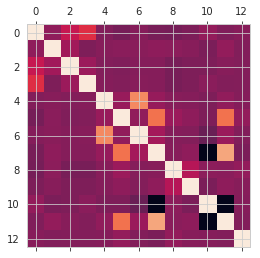

In [50]:
corr = corrdf.corr(method='pearson')
plt.matshow(corrdf.corr(method='pearson'))

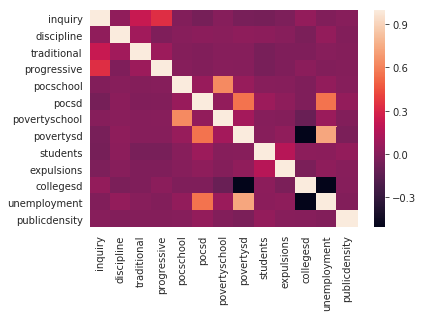

In [52]:
corr = corrdf.corr(method='pearson')
heatcorr = sns.heatmap(corr, 
                       xticklabels=corr.columns.values,
                       yticklabels=corr.columns.values)

heatcorr

In [ ]:
fig = heatcorr.get_figure()
fig.savefig(dir_prefix + "../../Charter-school-identities/data/heatcorr_112918.png")